<a href="https://colab.research.google.com/github/Bassendiaye/lowdiscovery/blob/main/notebooks/Split_offline_4000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision albumentations matplotlib sklearn pillow timm

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
import cv2
from collections import defaultdict
from uuid import uuid4
from tqdm import tqdm

In [3]:
# 1. Analyse et visualisation de la distribution des classes
def plot_class_distribution(data_dir):
  # Dictionnaire pour stocker le nombre d'images par classe
  repartition = {}

  # Extensions d'images
  extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

  # Comptage des images
  for nom_classe in os.listdir(data_dir):
      chemin_classe = os.path.join(data_dir, nom_classe)
      if os.path.isdir(chemin_classe):
          nb_images = len([f for f in os.listdir(chemin_classe) if f.lower().endswith(extensions)])
          repartition[nom_classe] = nb_images

  # Calcul des pourcentages
  total_images = sum(repartition.values())
  repartition_pourcentages = {classe: (nb / total_images) * 100 for classe, nb in repartition.items()}

  # -------- GRAPHE À BARRES --------
  plt.figure(figsize=(10, 6))
  bars = plt.bar(repartition.keys(), repartition.values(), color='skyblue')
  plt.xlabel("Classes")
  plt.ylabel("Nombre d'images")
  plt.title("Répartition des images par classe")
  plt.xticks(rotation=45)

  # Affichage des pourcentages au-dessus des barres
  for bar in bars:
      hauteur = bar.get_height()
      classe = bar.get_x() + bar.get_width() / 2
      pourcentage = (hauteur / total_images) * 100
      plt.text(classe, hauteur + 1, f"{pourcentage:.1f}%", ha='center', va='bottom', fontsize=10, color='black')

  plt.tight_layout()
  plt.show()
  return repartition

In [4]:
def prepare_data_with_oversampling(data_dir, test_size=0.3, random_state=42, max_samples_per_class=4000):

    IMG_HEIGHT = 46
    IMG_WIDTH = 322

    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    file_paths, labels = [], []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        class_files = [
            os.path.join(class_dir, f)
            for f in os.listdir(class_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        file_paths.extend(class_files)
        labels.extend([class_idx] * len(class_files))

    train_files, val_files, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=test_size, stratify=labels, random_state=random_state
    )

    def get_individual_transforms():
        return [
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
            A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=1),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
            A.Defocus(radius=(3, 5), p=1),
            A.MotionBlur(blur_limit=(3, 5), p=1),
            A.GaussianBlur(blur_limit=(3, 5), p=1)
        ]

    def oversample_with_separate_transforms(files, labels):
        label_to_files = defaultdict(list)
        for f, l in zip(files, labels):
            label_to_files[l].append(f)

        transforms = get_individual_transforms()
        base_transform = A.Compose([
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2()
        ])

        AUG_DIR = os.path.join(os.path.dirname(data_dir), "/content/drive/MyDrive/Dossier_de_Basse/split_4000_images_balanced")
        os.makedirs(AUG_DIR, exist_ok=True)

        oversampled_files, oversampled_labels = [], []

        for label, file_list in tqdm(label_to_files.items(), desc="Balancing classes"):
            n = len(file_list)

            if n == max_samples_per_class:
                oversampled_files.extend(file_list)
                oversampled_labels.extend([label] * n)

            elif n > max_samples_per_class:
                sampled = random.sample(file_list, max_samples_per_class)
                oversampled_files.extend(sampled)
                oversampled_labels.extend([label] * max_samples_per_class)

            else:  # Sur-échantillonnage
                oversampled_files.extend(file_list)
                oversampled_labels.extend([label] * n)
                needed = max_samples_per_class - n
                idx = 0
                while needed > 0:
                    img_path = file_list[idx % n]
                    image = cv2.imread(img_path)
                    if image is None:
                        idx += 1
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    for t in transforms:
                        if needed <= 0:
                            break
                        composed = A.Compose([t, base_transform])
                        augmented = composed(image=image)
                        aug_tensor = augmented["image"]

                        aug_np = aug_tensor.permute(1, 2, 0).cpu().numpy()
                        aug_np = np.clip((aug_np * 0.5 + 0.5) * 255, 0, 255).astype("uint8")
                        aug_bgr = cv2.cvtColor(aug_np, cv2.COLOR_RGB2BGR)

                        new_path = os.path.join(AUG_DIR, f"{uuid4().hex}.jpg")
                        if cv2.imwrite(new_path, aug_bgr):
                            oversampled_files.append(new_path)
                            oversampled_labels.append(label)
                            needed -= 1
                    idx += 1

        return oversampled_files, oversampled_labels

    train_files, train_labels = oversample_with_separate_transforms(train_files, train_labels)

    return train_files, val_files, train_labels, val_labels, class_names

In [5]:
# 3. Dataset personnalisé avec Albumentations
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        image = np.array(image)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [6]:
def get_val_transform():
    return A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

In [7]:
# 5. Entraînement du modèle
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Dossier_de_Basse/split_4000_best_model.pth')

    return model

In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(loader.dataset)
    acc = running_corrects.double() / len(loader.dataset)

    return loss, acc

In [9]:
from tqdm import tqdm
def predict_image(image_path, model, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Transformations cohérentes avec l'entraînement
    transform = A.Compose([
        A.Resize(height=46, width=322),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    # Lecture de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image non trouvée : {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Appliquer la transformation
    augmented = transform(image=image)
    tensor_image = augmented['image'].unsqueeze(0).to(device)  # Ajouter la dimension batch

    # Prédiction
    model.eval()
    with torch.no_grad():
        outputs = model(tensor_image)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = class_names[predicted_idx.item()]
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    return predicted_class, predicted_idx.item(), probabilities

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_test_transform():
    return A.Compose([
        A.Resize(height=46, width=322),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

def generate_confusion_matrix(model, test_files, test_labels, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    transform = get_test_transform()

    for img_path, label in tqdm(zip(test_files, test_labels), total=len(test_files), desc="Évaluation"):
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)
        tensor_image = augmented['image'].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(tensor_image)
            predicted = torch.argmax(output, dim=1).item()

        y_true.append(label)
        y_pred.append(predicted)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.tight_layout()
    plt.show()

In [11]:
def get_test_transform():
    return A.Compose([
        A.Resize(height=46, width=322),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

def generate_confusion_matrix(model, test_files, test_labels, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    transform = get_test_transform()

    for img_path, label in tqdm(zip(test_files, test_labels), total=len(test_files), desc="Évaluation"):
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)
        tensor_image = augmented['image'].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(tensor_image)
            predicted = torch.argmax(output, dim=1).item()

        y_true.append(label)
        y_pred.append(predicted)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.tight_layout()
    plt.show()

In [12]:
#***********************************************************************************************
# 1. Configuration
DATA_DIR = "/content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/train_Val"
BATCH_SIZE = 32
NUM_EPOCHS = 100

IMG_WIDTH = 224    # Largeur des images après redimensionnement
IMG_HEIGHT = 224     # Hauteur des images après redimensionnement
patch_size = 16     # Taille des patches

# Calcul du nombre de patches horizontaux et verticaux
num_patches_w = IMG_WIDTH // patch_size
num_patches_h = IMG_HEIGHT // patch_size
# Taux d'apprentissage (learning rate)
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Analyse de la distribution des classes...


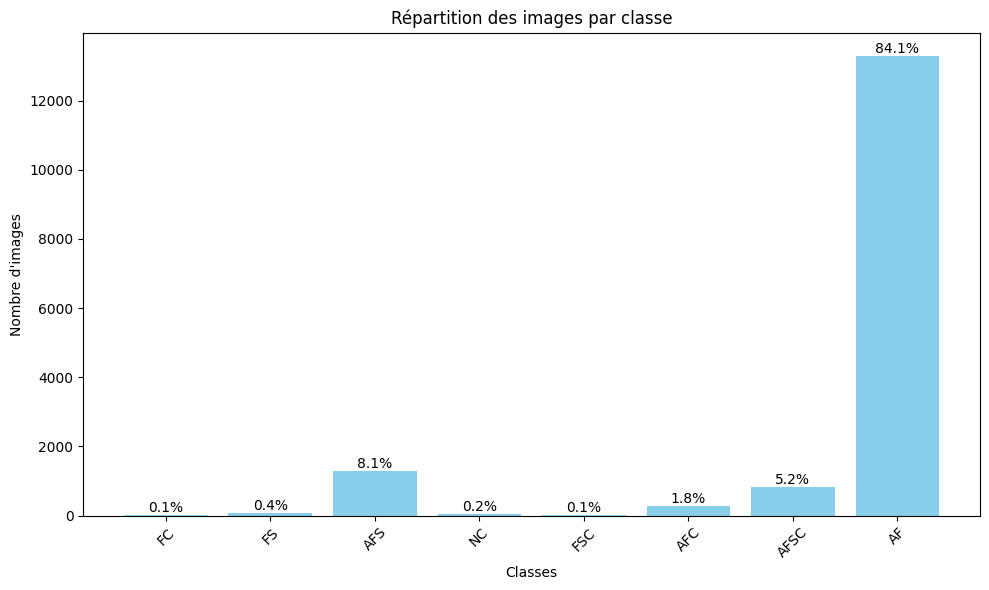

In [13]:
# 2. Analyse des données
print("Analyse de la distribution des classes...")
class_counts = plot_class_distribution(DATA_DIR)

In [14]:
print("DATA_DIR =", DATA_DIR)
print("Sous-dossiers dans DATA_DIR :", os.listdir(DATA_DIR))
for d in os.listdir(DATA_DIR):
    # Check if the entry is a directory before listing its contents
    full_path = os.path.join(DATA_DIR, d)
    if os.path.isdir(full_path):
        print(f"{d} → {len(os.listdir(full_path))} fichiers")
    else:
        print(f"{d} → Not a directory")

DATA_DIR = /content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/train_Val
Sous-dossiers dans DATA_DIR : ['FC', 'FS', 'AFS', 'NC', 'FSC', 'AFC', 'AFSC', 'AF']
FC → 13 fichiers
FS → 66 fichiers
AFS → 1280 fichiers
NC → 38 fichiers
FSC → 15 fichiers
AFC → 280 fichiers
AFSC → 830 fichiers
AF → 13296 fichiers


In [15]:
# 3. Préparation des données avec oversampling
print("\nPréparation des données avec oversampling...")
train_files, val_files, train_labels, val_labels, class_names = prepare_data_with_oversampling(DATA_DIR)
len(train_files), len(val_files)


Préparation des données avec oversampling...


/tmp/ipython-input-3558038153.py:27: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1),
Balancing classes: 100%|██████████| 8/8 [12:53<00:00, 96.66s/it]


(32000, 4746)

Distribution des labels d'entraînement après oversampling...


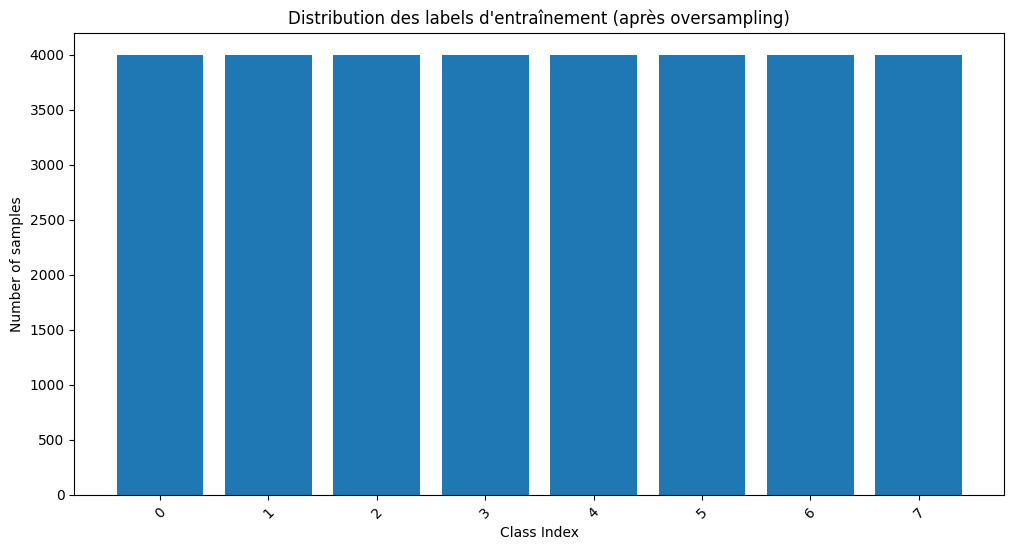

In [16]:
# Afficher les distributions des labels (listes d'entiers)
def plot_label_distribution(labels, title):
    """Plots the distribution of labels in a list."""
    label_counts = Counter(labels)
    # Sort by label index for consistent plotting
    sorted_labels = sorted(label_counts.keys())
    sorted_counts = [label_counts[label] for label in sorted_labels]

    plt.figure(figsize=(12, 6))
    plt.bar([str(label) for label in sorted_labels], sorted_counts) # Convert labels to string for x-axis
    plt.title(title)
    plt.xlabel('Class Index')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=45)
    plt.show()

print("Distribution des labels d'entraînement après oversampling...")
plot_label_distribution(train_labels, 'Distribution des labels d\'entraînement (après oversampling)')


Distribution des labels de test...


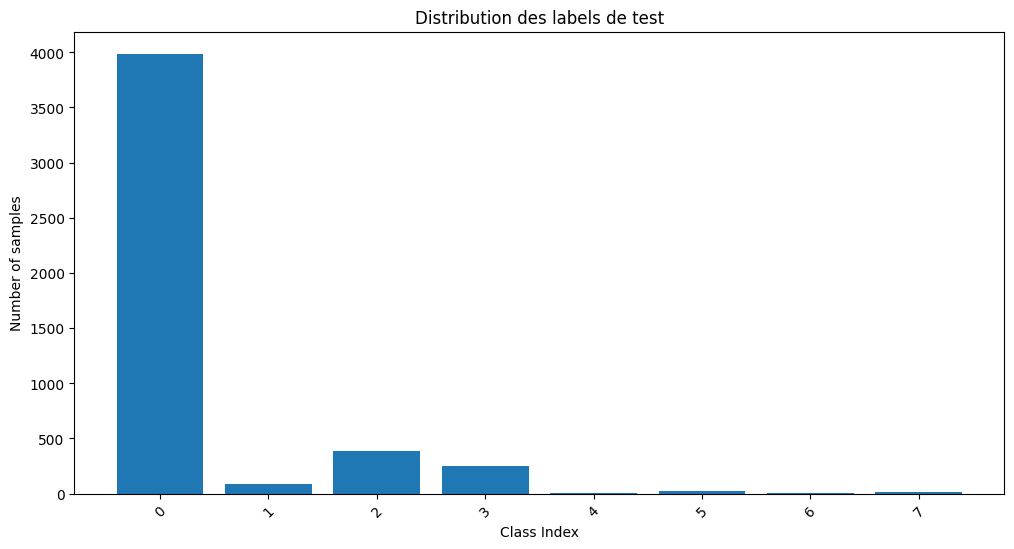

In [17]:
print("\nDistribution des labels de test...")
plot_label_distribution(val_labels, 'Distribution des labels de test')

In [18]:
# 4. Création des datasets et dataloaders
print("\nCréation des datasets et dataloaders...")
train_dataset = CustomDataset(train_files, train_labels, transform=get_val_transform())
val_dataset = CustomDataset(val_files, val_labels, transform=get_val_transform())


Création des datasets et dataloaders...


In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
import timm
# 5. Initialisation du modèle pré-entraîné deit_small
num_classes = len(class_names)
model = timm.create_model("deit_small_patch16_224", pretrained=True, num_classes=num_classes).to(device)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [21]:
# 6. Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)

In [ ]:
# 7. Entraînement
print("\nDébut de l'entraînement...")
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

print("Entraînement terminé !")


Début de l'entraînement...


# Task
Evaluate the trained model on the test dataset located at `/content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/test_set`. This involves loading the test images and their labels, creating a `CustomDataset` and `DataLoader` for the test set, calculating the test loss and accuracy, and finally generating a confusion matrix to visualize the model's performance on unseen data.

## Define Test Data Directory

### Subtask:
Define a new variable `TEST_DATA_DIR` pointing to the directory containing your test images.


**Reasoning**:
The subtask requires defining a new variable `TEST_DATA_DIR` and assigning a specified string value to it. This can be directly achieved using a Python code block.



In [1]:
TEST_DATA_DIR = "/content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/test_set"
print(f"TEST_DATA_DIR defined as: {TEST_DATA_DIR}")

TEST_DATA_DIR defined as: /content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/test_set


**Reasoning**:
To prepare the test data for evaluation, I need to extract the file paths of images and their corresponding class labels from the `TEST_DATA_DIR`. This step is crucial for creating the test dataset.



**Reasoning**:
The previous code failed because the 'os' module, which is necessary for file system operations like listing directories and joining paths, was not imported. I need to add `import os` to resolve this `NameError`.



In [3]:
import os

print("Collecting test image file paths and labels...")

test_files = []
test_labels = []

# Assuming 'class_names' was already defined during the training data preparation
# and represents the ordered list of class names.
# If not, it needs to be defined here from TEST_DATA_DIR as well, but for now,
# we assume it's available from the previous step (class_names variable).

# Ensure class_names is available, if not, generate it from TEST_DATA_DIR
if 'class_names' not in locals():
    print("Class names not found, generating from TEST_DATA_DIR...")
    class_names = sorted([d for d in os.listdir(TEST_DATA_DIR) if os.path.isdir(os.path.join(TEST_DATA_DIR, d))])
    print(f"Generated class_names: {class_names}")

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DATA_DIR, class_name);
    if os.path.isdir(class_dir):
        files_in_class = [
            os.path.join(class_dir, f)
            for f in os.listdir(class_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]
        test_files.extend(files_in_class)
        test_labels.extend([class_idx] * len(files_in_class))

print(f"Found {len(test_files)} test images.")
print(f"First 5 test files: {test_files[:5]}")
print(f"First 5 test labels: {test_labels[:5]}")

Class names not found, generating from TEST_DATA_DIR...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dossier_de_Basse/Data_paper_T_V_T/test_set'

**Reasoning**:
The `FileNotFoundError` indicates that the specified `TEST_DATA_DIR` does not exist on the file system. To address this, I will add an explicit check using `os.path.exists()` to verify the directory's presence. If the directory is missing, an informative error message will be printed, guiding the user to confirm the path, thus preventing the `FileNotFoundError` from crashing the execution. Additionally, I will refine the `class_names` check to ensure it correctly references the global scope and handles cases where `class_names` might be empty.



In [ ]:
import os

print("Collecting test image file paths and labels...")

test_files = []
test_labels = []

# Ensure class_names is available, if not, generate it from TEST_DATA_DIR
# It's better to ensure class_names from the training data is available and consistent.
# If class_names was generated in previous steps, it should be reused.
# Otherwise, generate from the test directory structure.

# Check if class_names is already defined from training (e.g., from prepare_data_with_oversampling)
if 'class_names' not in globals() or not class_names: # Check if exists AND is not empty
    print("Class names not found or empty, attempting to generate from TEST_DATA_DIR...")
    if not os.path.exists(TEST_DATA_DIR): # Added check for directory existence
        print(f"Error: TEST_DATA_DIR '{TEST_DATA_DIR}' does not exist. Please verify the path and ensure it's accessible.")
        # No further processing can happen if the directory is missing
        class_names = [] # Set to empty to prevent subsequent loops
    else:
        class_names = sorted([d for d in os.listdir(TEST_DATA_DIR) if os.path.isdir(os.path.join(TEST_DATA_DIR, d))])
        if not class_names:
            print(f"Warning: No class subdirectories found in '{TEST_DATA_DIR}' to infer class names.")
        else:
            print(f"Generated class_names from TEST_DATA_DIR: {class_names}")
else:
    print(f"Using existing class_names: {class_names}")

# If class_names couldn't be determined, we cannot proceed with label collection
if not class_names:
    print("Cannot proceed with test data preparation: class names are not defined or could not be inferred.")
else:
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(TEST_DATA_DIR, class_name);
        if os.path.isdir(class_dir):
            files_in_class = [
                os.path.join(class_dir, f)
                for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
            ]
            test_files.extend(files_in_in_class)
            test_labels.extend([class_idx] * len(files_in_class))
        else:
            print(f"Warning: Class directory '{class_dir}' not found within TEST_DATA_DIR. Skipping class '{class_name}'.")

print(f"Found {len(test_files)} test images.")
print(f"First 5 test files: {test_files[:5]}")
print(f"First 5 test labels: {test_labels[:5]}")